# Episode 2: Single-Qubit Gates, Bloch Sphere & Measurement (Qiskit Toolkit)

*In this session, we’ll explore single-qubit gates using Qiskit & Quantum Rings Toolkit, visualize states on the Bloch sphere, and measure outcomes.*

**NOTE:** Successful completion of this course will depend upon your engagement. The circuits in the coding notebooks have names which can be tracked in your execution history in Quantum Rings. We will verify your participation before you can earn a badge.

## Objectives
1. Apply X, Y, Z, H, S, and T gates using Qiskit circuits<br/>

2. Execute circuits on the Quantum Rings noise-free backend via the Toolkit<br/>

3. Visualize resulting states on the Bloch sphere with Qiskit visualization

4. Explore the BB84 QKD Protocol

In [1]:
# === 1. Setup & Imports
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import copy
from qiskit.circuit.library import RVGate, StatePreparation
from io import BytesIO
from IPython.display import HTML
from PIL import Image
from matplotlib.animation import FuncAnimation
from jupyterquiz import display_quiz

# Load saved account and select noise-free backend
provider = QuantumRingsProvider()
backend = provider.get_backend("scarlet_quantum_rings")

## Helper Functions

### Helper Function: Run & Plot
This function runs on the QR backend (counts) and shows a Bloch sphere of the pre-measurement state.

In [2]:
def run_and_plot(qc: QuantumCircuit, label: str):
    # a) Initialize a QrBackendV2 for exactly the size of your circuit
    num_qubits = qc.num_qubits
    qr_backend = QrBackendV2(provider=provider, num_qubits=num_qubits+1)

    # b) Execute on Quantum Rings
    job    = qr_backend.run(qc, shots=1024)
    result = job.result()
    print(f"{label} counts: {result.get_counts()}")

    # c) Strip measurements for statevector simulation
    qc_sv = qc.remove_final_measurements(inplace=False)
    sv    = Statevector.from_instruction(qc_sv)

    # d) Plot Bloch sphere for a single qubit
    fig = plot_bloch_multivector(sv.data, title=f"{label} — Bloch Sphere")
    display(fig)

### Helper Function: Gate Animations

This function uses Qiskit visualization for an arbitrary quantum gate, defined by a rotation axis and angle of rotation.

In [3]:
def gate(initial_state, rotation_axis, t):
    
    qc = QuantumCircuit(1)

    stateprep = StatePreparation(initial_state)
    qc.append(stateprep, [0])

    # rescale by time
    vector = 2*np.pi*t * rotation_axis

    gate = RVGate(vector[0],vector[1],vector[2])

    qc.append(gate, [0])
    
    sv = Statevector.from_instruction(qc)

    return sv

def gate_animation(rotation_axis, initial_state=[1,0], rotation_angle=np.pi, 
                   num_frames=21, interval=100, repeat=False):

    # normalize
    rotation_axis = np.array(rotation_axis)
    length = np.sqrt(np.sum(rotation_axis**2))
    normalized_axis = rotation_axis/length

    # Generate all Bloch vector images
    frames = []
    for i in range(0, num_frames+1):
        t = i / num_frames
        bloch = gate(initial_state, normalized_axis, t * rotation_angle/(2*np.pi))

        alpha, beta = bloch.data  # amplitudes for |0> and |1>

        # Compute Bloch vector
        x = 2 * np.real(np.conj(alpha) * beta)
        y = 2 * np.imag(np.conj(alpha) * beta)
        z = np.abs(alpha)**2 - np.abs(beta)**2
        
        bloch_vector = [x, y, z]
        
        fig = plot_bloch_multivector(bloch)
        b = Bloch()
        b.add_vectors(normalized_axis)  # add the rotation axis vector
        b.add_annotation(rotation_axis, "Rotation Axis", fontsize=16)
        b.add_vectors(bloch_vector)  # add the state vector
        
        buf = BytesIO()
        b.save(name=buf)
        buf.seek(0)
        img = Image.open(buf)
        frames.append(img.copy())
        plt.close(fig)

    # Convert PIL Images to NumPy arrays
    frame_arrays = [np.asarray(img) for img in frames]
    
    # Set up figure
    fig, ax = plt.subplots()
    im = ax.imshow(frame_arrays[0])
    ax.axis('off')  # Optional: hide axes
    
    # Update function for animation
    def update(frame_index):
        im.set_array(frame_arrays[frame_index])
        return [im]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(frame_arrays), interval=interval, repeat=repeat)
    
    # Display inline
    plt.close(fig)
    return HTML(ani.to_jshtml())

### Helper function: Convert to Basis String

This function converts a string of bits (0 or 1) to a string of bases (Z or X) for the BB84 protocol.

In [4]:
def convert_to_basis_string(arr):

    arr = copy.deepcopy(arr)
    arr = np.array(arr, dtype=object)
    arr[arr == 0] = 'Z'
    arr[arr == 1] = 'X'

    return arr

## 1. Single Qubit Gates

We learned about 6 single qubit gates today. The X, Y, and Z gates are 180° rotations about their respective axes. The Hadamard gate is a 180° rotation around the axis which lies at 45° in the XZ-plane. The S and T gates are $\pi$/2 and $\pi$/4 rotations around the Z axis.

Their matrix representations are as follows:

$$ X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} $$

$$ Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} $$

$$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$

$$ H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} $$

$$ S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix} $$

$$ T = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{pmatrix} $$

Generally speaking, every single qubit gate is a rotation. Our allowed qubit states lie on the surface of the Bloch sphere, so any qubit state can be transformed to any other via a rotation (a.k.a. a gate).

### Check your understanding: Unitary and Hermitian Matrices

Recall that unitary matrices satisfy $UU^\dagger = U^\dagger U = \mathbb{1}$ and Hermitian matrices satisfy $A = A^\dagger$.

<div class="sec1_ques1" style="display:none">
[
  {
    "question": "Of the six gates shown above, which are unitary?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"All of them.","correct":true,  "feedback":"✅ All gates need to be unitary because they need to preserve the norm of a qubit state."},
      {"answer":"Only X, Y, and Z.","correct":false, "feedback":"❌"},
      {"answer":"Only X, Y, Z, and H","correct":false, "feedback":"❌"},
    {"answer":"Only S and T","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec1_ques2" style="display:none">
[
  {
    "question": "Of the six gates shown above, which are Hermitian?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"All of them.","correct":false,  "feedback":"❌"},
      {"answer":"Only X, Y, and Z.","correct":false, "feedback":"❌"},
      {"answer":"Only X, Y, Z, and H","correct":true, "feedback":"✅ S and T are not equal to their Hermitian conjugates. Only operators which correspond to physical observables need to be Hermitian, which S and T are not."},
    {"answer":"Only S and T","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec1_ques3" style="display:none">
[
  {
    "question": "Which gate is the 'bit flip' gate?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"X","correct":true,  "feedback":"✅"},
      {"answer":"Y","correct":false, "feedback":"❌"},
      {"answer":"Z","correct":false, "feedback":"❌"},
    {"answer":"H","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec1_ques4" style="display:none">
[
  {
    "question": "Which gate is the 'phase flip' gate?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"Z","correct":true,  "feedback":"✅"},
      {"answer":"Y","correct":false, "feedback":"❌"},
      {"answer":"X","correct":false, "feedback":"❌"},
    {"answer":"H","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec1_ques5" style="display:none">
[
  {
    "question": "Which gate puts the 0 state into an equal superposition of 0 and 1?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"H","correct":true,  "feedback":"✅"},
      {"answer":"Y","correct":false, "feedback":"❌"},
      {"answer":"Z","correct":false, "feedback":"❌"},
    {"answer":"X","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

In [25]:
display_quiz("#sec1_ques1")
display_quiz("#sec1_ques2")
display_quiz("#sec1_ques3")
display_quiz("#sec1_ques4")
display_quiz("#sec1_ques5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Gate Demonstrations

We can use Qiskit to apply gates and visualize the action of those gates. The function run_and_plot() shows us the final state of a quantum circuit. Note that by default, our qubit starts in the 0 state.

X gate counts: {'1': 1024}


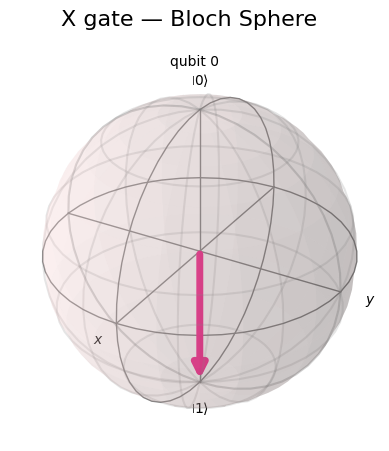

In [8]:
# X gate demo
qc_x = QuantumCircuit(1,1, name='qss25.2 X')
qc_x.x(0)
qc_x.measure(0,0)
run_and_plot(qc_x, 'X gate')

Y gate counts: {'1': 1024}


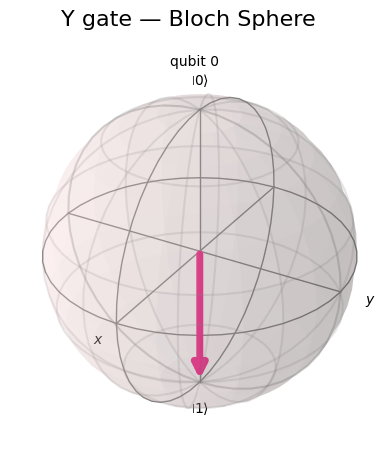

In [32]:
# Y gate 
qc_y = QuantumCircuit(1, 1)
qc_y.y(0)
qc_y.measure(0, 0)
run_and_plot(qc_y, 'Y gate')

Z gate counts: {'0': 1024}


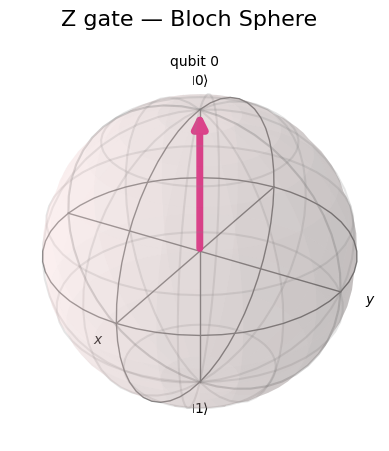

In [33]:
# Z gate 
qc_z = QuantumCircuit(1, 1)
qc_z.z(0)
qc_z.measure(0, 0)
run_and_plot(qc_z, 'Z gate')

H gate (|+>) counts: {'0': 499, '1': 525}


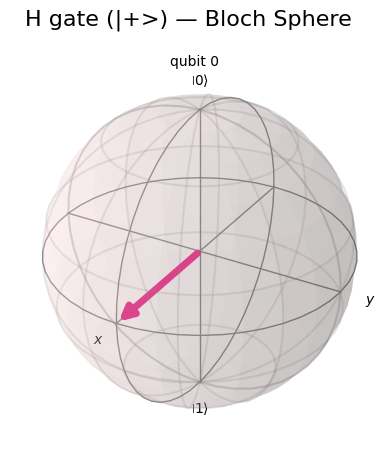

In [34]:
# Hadamard gate prepares |+> superposition
qc_h = QuantumCircuit(1, 1)
qc_h.h(0)
qc_h.measure(0, 0)
run_and_plot(qc_h, 'H gate (|+>)')

In [ ]:
# Now check the action of the Z gate on the |+> state.



S gate counts: {'0': 495, '1': 529}


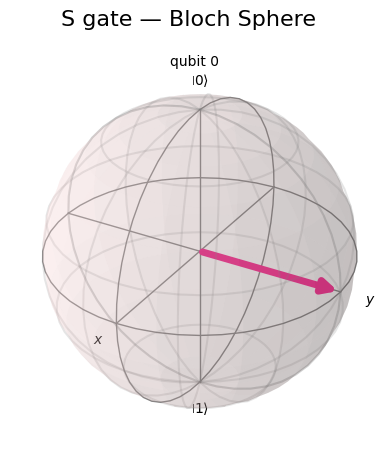

In [35]:
# S and T gates (phase shifts) on |+>
qc_s = QuantumCircuit(1, 1)
qc_s.h(0)
qc_s.s(0)
qc_s.measure(0, 0)
run_and_plot(qc_s, 'S gate')

T gate counts: {'0': 528, '1': 496}


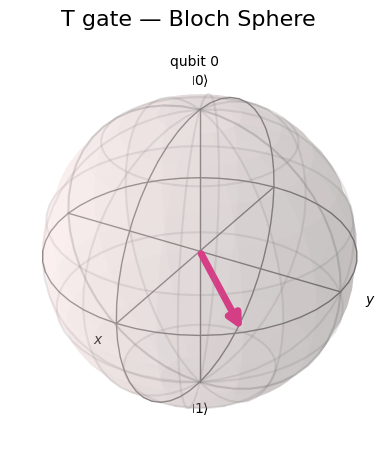

In [36]:
qc_t = QuantumCircuit(1, 1)
qc_t.h(0)
qc_t.t(0)
qc_t.measure(0, 0)
run_and_plot(qc_t, 'T gate')

### Check your understanding: Single Qubit Gates

<div class="sec2_ques1" style="display:none">
[
  {
    "question": "If you apply HZH, which gate is that equivalent to? Think about the result of HZH|0> and HZH|1>.",
    "type": "multiple_choice",
    "answers": [
      {"answer":"X","correct":true,  "feedback":"✅"},
      {"answer":"Y","correct":false, "feedback":"❌"},
      {"answer":"S","correct":false, "feedback":"❌"},
    {"answer":"T","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec2_ques2" style="display:none">
[
  {
    "question": "How can you prepare the state |+i>?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"SH|0>","correct":true,  "feedback":"✅"},
      {"answer":"SZHX|0>","correct":true, "feedback":"✅"},
      {"answer":"TH|0>","correct":false, "feedback":"❌"},
    {"answer":"TTHX|0>","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

In [41]:
display_quiz("#sec2_ques1")
display_quiz("#sec2_ques2")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Gate Animations

We can also make animations of the gate over time. In practice, quantum gates are not applied instantaneously, but over a period of time as a rotation. We call this unitary evolution, because our quantum state is evolving under a unitary operator.

Below, you can make animations of an arbitrary rotation, just specify the axis of rotation, the angle to rotate, and the initial state. Note: the initial state needs to be a valid quantum state (i.e. norm of 1). Please be patient as the animations may take a bit to render.

**Recreate the X gate:** Define the X gate, but starting from the state $|+i\rangle$.

In [5]:
axis = [1,0,0]
rotation_angle = np.pi
initial_state = [1/np.sqrt(2),1j/np.sqrt(2)]

gate_animation(axis, initial_state=initial_state, rotation_angle=rotation_angle)

**Get creative!** Try defining your own rotation axes and angles and see how your gate looks!

In [ ]:
## Your code here!

## 4. Measurement

Let's explore the nature of quantum measurement. We know that our qubit exists in a superposition state prior to measurement, but the **only possible measurement results** are 0 and 1. Let's think about what we can learn from measuring a qubit.

In [7]:
# Quantum Rings backend to use throughout this section
backend = QrBackendV2(provider=provider, num_qubits=2) # num_qubits is plus one from physical number

**A) $|+\rangle$ vs. $|-\rangle$**

Let's make a circuit which prepares the $|+\rangle$ state and measures the qubit, and let's repeat the measurement 1000 times.

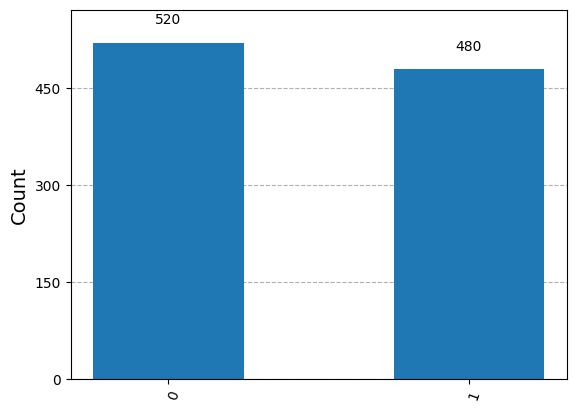

In [9]:
qc = QuantumCircuit(1, 1, name='qss25.2 plus_measurement')

# prepare |+ >
qc.h(0)

qc.measure(0, 0)

job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

Now let's make a circuit which prepares the $|-\rangle$ state and measures the qubit, and let's repeat the measurement 1000 times.

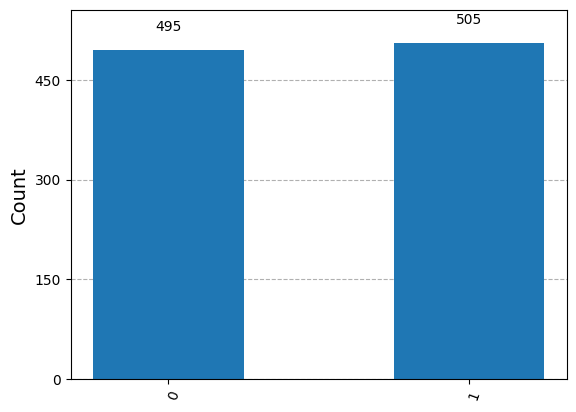

In [10]:
qc = QuantumCircuit(1, 1, name='qss25.2 minus_measurement')

# prepare |- >
qc.x(0)
qc.h(0)

qc.measure(0, 0)

job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

**Question:** Can we tell the $|+\rangle$ and $|-\rangle$ states apart based upon these measurements? If not, what information do we learn?

**Question:** What can we do before measurement to be able to distinguish (with 100% certainty!) between the $|+\rangle$ and $|-\rangle$ states?

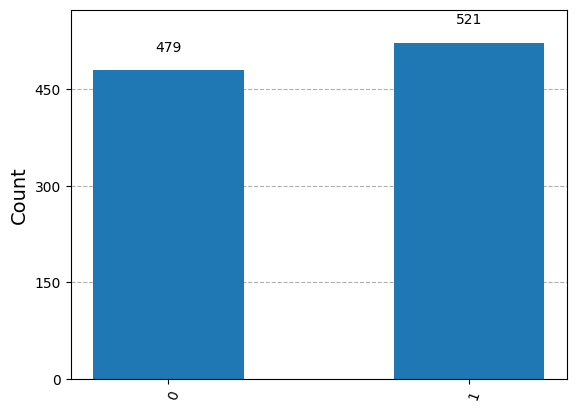

In [12]:
qc = QuantumCircuit(1, 1, name = 'qss25.2 X basis 1')

# prepare |+ >
qc.h(0)

# Rotate into the X basis
## ?

qc.measure(0, 0)

job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

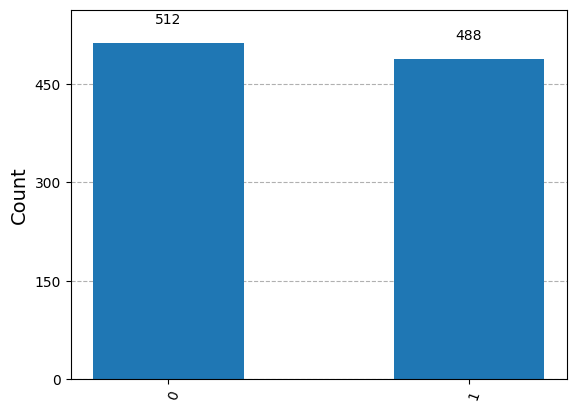

In [13]:
qc = QuantumCircuit(1, 1, name = 'qss25.2 X basis 2')

# prepare |- >
qc.x(0)
qc.h(0)

# Rotate into the X basis
## ?

qc.measure(0, 0)

job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
qc = QuantumCircuit(1, 1)

# prepare |- >
qc.x(0)
qc.h(0)

# add a Hadamard before measurement to rotate into the x basis
qc.h(0)
qc.measure(0, 0)

job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Challenge Problem: 

Can you come up with a protocol for measurement which can distinguish between the $|+i\rangle$ and $|-i\rangle$ states? Check if it works by making circuits which prepare the $|+i\rangle$ and $|-i\rangle$ states and apply your protocol.

### Check your understanding: Measurement

<div class="sec5_ques1" style="display:none">
[
  {
    "question": "Suppose you measure your qubit and get 0 as your result. You leave the qubit as is and come back later and measure again. What will you get?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"0","correct":true,  "feedback":"✅ The qubit state stays collapsed in the 0 state after measurement."},
      {"answer":"1","correct":false, "feedback":"❌"},
      {"answer":"It could be 0 or 1.","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec5_ques2" style="display:none">
[
  {
    "question": "Can you tell the difference between the 0 and + states with 100% certainty with one measurement?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"No","correct":true,  "feedback":"✅ The 0 and + states have nonzero overlap, so you can't tell them apart from one measurement."},
      {"answer":"Yes","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

<div class="sec5_ques3" style="display:none">
[
  {
    "question": "Can you tell the difference between the + and +i states with 100% certainty with one measurement?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"No","correct":true,  "feedback":"✅ The + and +i states have nonzero overlap, so you can't tell them apart from one measurement."},
      {"answer":"Yes","correct":false, "feedback":"❌"}
    ]
  }
]
</div>

In [17]:
display_quiz("#sec5_ques1")
display_quiz("#sec5_ques2")
display_quiz("#sec5_ques3")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. BB84 protocol?

We learned today about a QKD (quantum key distribution) protocol called BB84, which leverages quantum superposition to securely create a shared key between two users (who we often call Alice and Bob). Alice and Bob will also be able to detect if anyone tries to "eavesdrop" to learn the key. All that is required for BB84 is a quantum channel and a classical communication channel, neither of which need to be secure. We summarize the steps of the protocol here:

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

1. Alice randomly chooses a bit string of length $n$: $b_1 b_2 \cdots b_n$
2. Alice randomly chooses measurement basis $Z$ or $X$ for each of the $n$ bits. 
3. Bob randomly chooses measurement basis $Z$ or $X$ for each of the $n$ bits. 
4. Repeat the following steps for $i$ in $1,2,\dots n$:

    - Alice prepares the state $|b_i\rangle$ in the basis she has chosen for the ith bit.
    - Alice sends the qubit to Bob via a quantum channel.
    - Bob measures the qubit in the basis he has chosen for the ith bit to obtain a measured bit $m_i$. 


5. Alice and Bob compare their choice of bases, over a classical channel. For each $i$ in $1,2,\dots n$, if their choice of basis agrees, Alice adds $b_i$ to her version of the shared key and Bob adds $m_i$ to his version of the shared key. Otherwise, they discard the bit.

6. Finally, they choose some fraction of the bits in their shared key and compare them over a classical channel. (Note: these bits can no longer be used in the shared key.) If they are in agreement, they keep the remaining bits as their shared key. If there are any discrepancies, they know that someone tried to eavesdrop and they discard their keys.

</div>

We can summarize all 8 possibilities (per qubit) in the following chart:

| Alice's bit &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Alice's Basis &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Bob's Basis &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Bit added to shared key? &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
| 0  |  Z  | Z | Yes |
| 1  |  Z  | Z | Yes |
| 0  |  X  | Z | No |
| 1  |  X  | Z | No |
| 0  |  Z  | X | No |
| 1  |  Z  | X | No |
| 0  |  X  | X | Yes |
| 1  |  X  | X | Yes |

In [18]:
# BB84 Protocol

n = 5 # number of bits

# randomly choose Alice's bits and bases, and Bob's bases
alice_bits = np.random.choice([0,1], n)
alice_bases = np.random.choice([0,1], n)
bob_bases = np.random.choice([0,1], n)

bob_bits = np.zeros(len(alice_bits), dtype=int) # list to store Bob's measurement results

# simulator backend
backend = QrBackendV2(provider=provider, num_qubits=2)

# loop through all bits
for i in range(n):
    
    print(f"Bit #{i+1}")
    print(f"Alice Bit: {alice_bits[i]}, Alice Basis: {'Z' if alice_bases[i]==0 else 'X'}, Bob Basis: {'Z' if bob_bases[i]==0 else 'X'}" )

    qc = QuantumCircuit(1,0,name='qss25.2 BB84') # 1 QB circuit
    
    # bit flip if preparing the |1> state
    if alice_bits[i] == 1:
        qc.x(0)
        
    # H gate if X basis
    if alice_bases[i] == 1:
        qc.h(0)
        
    qc.barrier() # visual barrier between Alice and Bob's steps
        
    # H gate if X basis
    if bob_bases[i] == 1:
        qc.h(0)
        
    qc.measure_all()
        
    display(qc.draw())

    # simulate for 1 shot
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    
    # save Bob's measurement result
    bob_bits[i] = 0 if '0' in counts.keys() else 1
    
    print(f"Bob measured {bob_bits[i]:.0f}")
    print()
    

Bit #1
Alice Bit: 0, Alice Basis: Z, Bob Basis: X


░ ┌───┐ ░ ┌─┐
     q: ─░─┤ H ├─░─┤M├
         ░ └───┘ ░ └╥┘
meas: 1/════════════╩═
                    0

Bob measured 0

Bit #2
Alice Bit: 0, Alice Basis: X, Bob Basis: X


┌───┐ ░ ┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤ H ├─░─┤M├
        └───┘ ░ └───┘ ░ └╥┘
meas: 1/═════════════════╩═
                         0

Bob measured 0

Bit #3
Alice Bit: 1, Alice Basis: X, Bob Basis: X


┌───┐┌───┐ ░ ┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├─░─┤ H ├─░─┤M├
        └───┘└───┘ ░ └───┘ ░ └╥┘
meas: 1/══════════════════════╩═
                              0

Bob measured 1

Bit #4
Alice Bit: 0, Alice Basis: Z, Bob Basis: Z


░  ░ ┌─┐
     q: ─░──░─┤M├
         ░  ░ └╥┘
meas: 1/═══════╩═
               0

Bob measured 0

Bit #5
Alice Bit: 1, Alice Basis: X, Bob Basis: Z


┌───┐┌───┐ ░  ░ ┌─┐
     q: ┤ X ├┤ H ├─░──░─┤M├
        └───┘└───┘ ░  ░ └╥┘
meas: 1/═════════════════╩═
                         0

Bob measured 0



In [24]:
# BB84 Protocol

n = 20 # number of bits

# randomly choose Alice's bits and bases, and Bob's bases
alice_bits = np.random.choice([0,1], n)
alice_bases = np.random.choice([0,1], n)
bob_bases = np.random.choice([0,1], n)

bob_bits = np.zeros(len(alice_bits), dtype=int) # list to store Bob's measurement results

# simulator backend
backend = QrBackendV2(provider=provider, num_qubits=2)

# loop through all bits
for i in range(n):
    
    qc = QuantumCircuit(1,0,name='qss25.2 BB84') # 1 QB circuit
    
    # bit flip if preparing the |1> state
    if alice_bits[i] == 1:
        qc.x(0)
        
    # H gate if X basis
    if alice_bases[i] == 1:
        qc.h(0)
        
    qc.barrier() # visual barrier between Alice and Bob's steps
        
    # H gate if X basis
    if bob_bases[i] == 1:
        qc.h(0)
        
    qc.measure_all()

    # simulate for 1 shot
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    
    # save Bob's measurement result
    bob_bits[i] = 0 if '0' in counts.keys() else 1


# Post-selection
print("Measurement Results:")
print(f"Alice's bitstring: {alice_bits}")
print(f"  Bob's bitstring: {bob_bits}")
print()
print("Basis Comparison:")
print(f"Alice's bases: {convert_to_basis_string(alice_bases)}")
print(f"  Bob's bases: {convert_to_basis_string(bob_bases)}")
print()

# only keep bits where the basis is in agreement
keep_idxs = alice_bases == bob_bases
alice_key = alice_bits[keep_idxs]
bob_key = bob_bits[keep_idxs]

print("Keys:")
print(f"Alice's key: {alice_key}")
print(f"  Bob's key: {bob_key}")
print()

Measurement Results:
Alice's bitstring: [1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1]
  Bob's bitstring: [1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0]

Basis Comparison:
Alice's bases: ['X' 'X' 'X' 'Z' 'X' 'Z' 'X' 'Z' 'Z' 'X' 'Z' 'Z' 'Z' 'X' 'X' 'Z' 'X' 'Z'
 'Z' 'X']
  Bob's bases: ['X' 'X' 'X' 'X' 'X' 'Z' 'X' 'Z' 'X' 'Z' 'Z' 'Z' 'X' 'X' 'Z' 'Z' 'Z' 'Z'
 'Z' 'Z']

Keys:
Alice's key: [1 0 0 1 0 1 0 1 0 0 0 1 1]
  Bob's key: [1 0 0 1 0 1 0 1 0 0 0 1 1]



### Comprehension Questions:

Run the above code a few times to get a sense for how the protocol works, then consider the following questions.

**A)** When Alice and Bob's bases are the same, does Bob's measured bit always match Alice's? 

**B)** When Alice and Bob's bases differ, does Bob's measured bit always match Alice's?

**Full Protocol**

In [ ]:
# Post-selection
print("Measurement Results:")
print(f"Alice's bitstring: {alice_bits}")
print(f"  Bob's bitstring: {bob_bits}")
print()
print("Basis Comparison:")
print(f"Alice's bases: {convert_to_basis_string(alice_bases)}")
print(f"  Bob's bases: {convert_to_basis_string(bob_bases)}")
print()

# only keep bits where the basis is in agreement
keep_idxs = alice_bases == bob_bases
alice_key = alice_bits[keep_idxs]
bob_key = bob_bits[keep_idxs]

print("Keys:")
print(f"Alice's key: {alice_key}")
print(f"  Bob's key: {bob_key}")
print()

**Adding in Eve:** Now let's add an eavesdropper to the mix. Our eavesdropper called Eve will try to learn Alice and Bob's key. Her attack will be to simply intercept and measure the qubit as it's going in the quantum channel between Alice and Bob. After measurement, she sends the qubit to Bob, hoping they won't notice...

In [20]:
# BB84 Protocol with Eve (simple measurement attack)

n = 3 # number of bits

# randomly choose Alice's bits and bases, and Bob's bases
alice_bits = np.random.choice([0,1], n)
alice_bases = np.random.choice([0,1], n)
bob_bases = np.random.choice([0,1], n)
bob_bits = np.zeros(len(alice_bits), dtype=int) # list to store Bob's measurement results
eve_bits = np.zeros(len(alice_bits), dtype=int) # list to store Eve's measurement results

# simulator backend
backend = QrBackendV2(provider=provider, num_qubits=2)

# quantum register for our qubit
qr = QuantumRegister(1, name="Qubit")
# create classical register with two bits -- one for Bob's measurement and one for Eve's
cr = ClassicalRegister(2)

# loop through all bits
for i in range(n):
    
    print(f"Bit #{i+1}")
    print(f"Alice Bit: {alice_bits[i]}, Alice Basis: {'Z' if alice_bases[i]==0 else 'X'}, Bob Basis: {'Z' if bob_bases[i]==0 else 'X'}" )
    
    qc = QuantumCircuit(qr, cr, name='qss25.2 BB84 with Eve') # 1 QB circuit
    
    # bit flip if preparing the |1> state
    if alice_bits[i] == 1:
        qc.x(0)
        
    # H gate if X basis
    if alice_bases[i] == 1:
        qc.h(0)
        
    qc.barrier() # visual barrier between Alice and Eve's steps
    
    # Eve measures the qubit
    qc.measure(qr, cr[0]) 
    
    qc.barrier() # visual barrier between Eve and Bob's steps
        
    # H gate if X basis
    if bob_bases[i] == 1:
        qc.h(0)
        
    qc.measure(qr, cr[1])
        
    display(qc.draw())

    # simulate for 1 shot
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    # extract counts -- the 0th index is right-most (potentially counterintuitive ordering)
    bob_counts = {key[0]: value for key, value in counts.items()} 
    eve_counts = {key[-1]: value for key, value in counts.items()} 
    
    # save Bob and Eve's measurement results
    bob_bits[i] = 0 if '0' in bob_counts.keys() else 1
    eve_bits[i] = 0 if '0' in eve_counts.keys() else 1
    
    print(f"Bob measured {bob_bits[i]:.0f}")
    print(f"Eve measured {eve_bits[i]:.0f}")
    print()
    

Bit #1
Alice Bit: 0, Alice Basis: Z, Bob Basis: Z


░ ┌─┐ ░ ┌─┐
Qubit: ─░─┤M├─░─┤M├
        ░ └╥┘ ░ └╥┘
 c0: 2/════╩═════╩═
           0     1

Bob measured 0
Eve measured 0

Bit #2
Alice Bit: 1, Alice Basis: X, Bob Basis: X


┌───┐┌───┐ ░ ┌─┐ ░ ┌───┐┌─┐
Qubit: ┤ X ├┤ H ├─░─┤M├─░─┤ H ├┤M├
       └───┘└───┘ ░ └╥┘ ░ └───┘└╥┘
 c0: 2/══════════════╩══════════╩═
                     0          1

Bob measured 0
Eve measured 1

Bit #3
Alice Bit: 0, Alice Basis: Z, Bob Basis: X


░ ┌─┐ ░ ┌───┐┌─┐
Qubit: ─░─┤M├─░─┤ H ├┤M├
        ░ └╥┘ ░ └───┘└╥┘
 c0: 2/════╩══════════╩═
           0          1

Bob measured 0
Eve measured 0



### Comprehension Questions:

Run the above code a few times to get a sense for how Eve's attack works, then consider the following questions.

**A)** When Alice and Bob's bases are the same, does Bob's measured bit always match Alice's? 

**B)** When Alice and Bob's bases differ, does Bob's measured bit always match Alice's?

**C)** How does Eve's measurement result compare to Alice's bit and Bob's measured bit?

**D)** Is Eve's method effective? Under what combo of bases for Alice and Bob can Eve go undetected?

**Full Protocol with Attack**

In [21]:
# BB84 Protocol

n = 20 # number of bits

# randomly choose Alice's bits and bases, and Bob's bases
alice_bits = np.random.choice([0,1], n)
alice_bases = np.random.choice([0,1], n)
bob_bases = np.random.choice([0,1], n)
bob_bits = np.zeros(len(alice_bits), dtype=int) # list to store Bob's measurement results
eve_bits = np.zeros(len(alice_bits), dtype=int) # list to store Eve's measurement results

# quantum register for our qubit
qr = QuantumRegister(1, name="Qubit")
# create classical register with two bits -- one for Bob's measurement and one for Eve's
cr = ClassicalRegister(2)

# loop through all bits
for i in range(n):
    
    qc = QuantumCircuit(qr, cr) # 1 QB circuit
    
    # bit flip if preparing the |1> state
    if alice_bits[i] == 1:
        qc.x(0)
        
    # H gate if X basis
    if alice_bases[i] == 1:
        qc.h(0)
        
    qc.barrier() # visual barrier between Alice and Eve's steps
    
    # Eve measures the qubit
    qc.measure(qr, cr[0]) 
    
    qc.barrier() # visual barrier between Eve and Bob's steps
        
    # H gate if X basis
    if bob_bases[i] == 1:
        qc.h(0)
        
    qc.measure(qr, cr[1])

    # simulate for 1 shot
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    # extract counts -- the 0th index is right-most (potentially counterintuitive ordering)
    bob_counts = {key[0]: value for key, value in counts.items()} 
    eve_counts = {key[-1]: value for key, value in counts.items()} 
    
    # save Bob and Eve's measurement results
    bob_bits[i] = 0 if '0' in bob_counts.keys() else 1
    eve_bits[i] = 0 if '0' in eve_counts.keys() else 1

    
# Post-selection
print("Measurement Results:")
print(f"Alice's bitstring: {alice_bits}")
print(f"  Bob's bitstring: {bob_bits}")
print(f"  Eve's bitstring: {eve_bits}")
print()
print("Basis Comparison:")
print(f"Alice's bases: {convert_to_basis_string(alice_bases)}")
print(f"  Bob's bases: {convert_to_basis_string(bob_bases)}")
print()

# only keep bits where the basis is in agreement
keep_idxs = alice_bases == bob_bases
alice_key = alice_bits[keep_idxs]
bob_key = bob_bits[keep_idxs]
# bases are compared over a public channel, so eve keeps the same indexed bits
eve_key = eve_bits[keep_idxs]

print("Keys:")
print(f"Alice's key: {alice_key}")
print(f"  Bob's key: {bob_key}")
print(f"  Eve's key: {eve_key}")
print()

Measurement Results:
Alice's bitstring: [1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0]
  Bob's bitstring: [0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1]
  Eve's bitstring: [1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1]

Basis Comparison:
Alice's bases: ['X' 'X' 'X' 'X' 'Z' 'X' 'X' 'X' 'Z' 'Z' 'X' 'X' 'X' 'X' 'X' 'X' 'Z' 'X'
 'X' 'X']
  Bob's bases: ['X' 'X' 'X' 'Z' 'Z' 'Z' 'Z' 'X' 'X' 'X' 'Z' 'Z' 'X' 'Z' 'Z' 'Z' 'X' 'Z'
 'Z' 'Z']

Keys:
Alice's key: [1 0 1 0 0 0]
  Bob's key: [0 1 1 0 0 0]
  Eve's key: [1 1 0 0 1 1]



**Challenge:** Another attack that Eve could try is the mimicry attack. She will pretend to be Bob! For each bit, Eve will also choose a basis. If she chooses Z, she simply measures the qubit like before. If she chooses X, she will apply a Hadamard before AND after measurement. Try implementing this version of the attack!

In [22]:
## Your code here!

**Challenge** Are there any other attacks you can think of? Why won't any of these approaches work for Eve?

----
### Next Up
**Episode 3: Entanglement & Multi-Qubit Gates**

We’ll create Bell pairs, GHZ states, and explore multi-qubit interactions.